# Training a network on representing an image (pure python) and interpreting the role of neurons

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 3, Code shown in the lecture

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- train a neural network trying to approximate an image
- 'opening the box': visualize what happens when some neurons are switched off

This uses the python backpropagation code shown in lecture 2

Note on programming style: I wanted to keep the code as close as possible to the backpropagation code in the lecture, which uses global variables (e.g. for the weights) for simplicity. However, if you wanted to nicely encapsulate this for usage by other people in larger projects, you would either (1) always make sure to pass along these variables as arguments (and never make them global) or (2) use object-oriented programming and turn this into a network class, which keeps these variables internally.

### Imports: only numpy and matplotlib

In [1]:
from numpy import array, zeros, exp, random, dot, shape, transpose, reshape, meshgrid, linspace, sqrt

from scipy import ndimage # for image loading/processing
import imageio

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

# Backpropagation

## Implement backpropagation for a general (fully connected) network

In [2]:
# implement a ReLU unit (rectified linear), which
# works better for training in this case
# def net_f_df(z): # calculate f(z) and f'(z)
#     val=z*(z>0)
#     return(val,z>0) # return both f and f'
def net_f_df(z):
    return([1/(1+exp(-z)), 
        1/((1+exp(-z))*(1+exp(z))) ]) # sigmoid

def forward_step(y,w,b): # calculate values in next layer, from input y
    z=dot(y,w)+b # w=weights, b=bias vector for next layer
    return(net_f_df(z)) # apply nonlinearity and return result

def apply_net(y_in): # one forward pass through the network
    global Weights, Biases, NumLayers
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers [not counting input]
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        df_layer[j]=df # store f'(z) [needed later in backprop]
        y_layer[j+1]=y # store f(z) [also needed in backprop]        
    return(y)

def apply_net_simple(y_in): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)

    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step
    return(y)

def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( dot(delta,transpose(w))*df )

def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)
    global batchsize
    
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=dot(transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=dot(transpose(y_layer[-3-j]),delta)/batchsize
        db_layer[-2-j]=delta.sum(0)/batchsize
        
def gradient_step(eta): # update weights & biases (after backprop!)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
        
def train_net(y_in,y_target,eta): # one full training batch
    # y_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost=0.5*((y_target-y_out_result)**2).sum()/batchsize
    return(cost)



### Train net to reproduce a 2D function

In [3]:
# load the pixel image!
face =imageio.imread('Smiley.png')
pixel_image=transpose(face[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=pixel_image.min()
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=shape(pixel_image)[0] # assuming a square image!

/var/folders/wm/d15_c33x1vvd15mnympdwv2h0000gn/T/ipykernel_14166/3901831230.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  face =imageio.imread('Smiley.png')


In [4]:
# the function we want to have (desired outcome)
# this picks the pixels from the image
def myFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.9999).astype(dtype='int')
    x1int=(x1*Npixels*0.9999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels


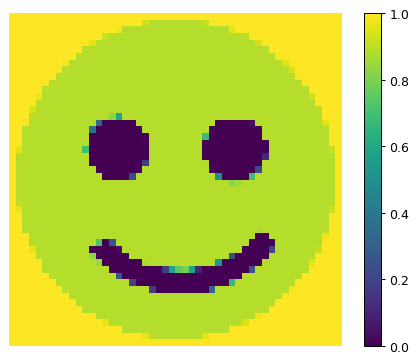

In [5]:
# check that this works:
Npixels_Test=50 # do the test output on a low-res grid! (saves time)
xrange=linspace(0,1,Npixels_Test)
X0,X1=meshgrid(xrange,xrange)
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower')
plt.axis('off')
plt.colorbar()
plt.show()

In [6]:
# pick 'batchsize' random positions in the 2D square
def make_batch():
    global batchsize

    inputs=random.uniform(low=0,high=1,size=[batchsize,2])
    targets=zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
    return(inputs,targets)

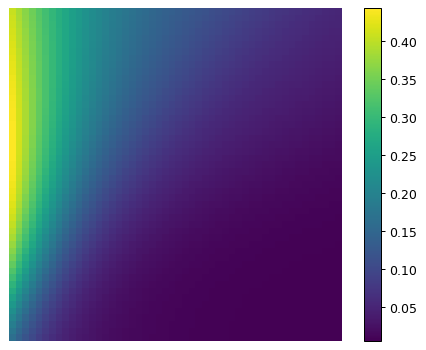

In [7]:
# set up all the weights and biases

NumLayers=3 # does not count input-layer (but does count output)
LayerSizes=[2,150,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[5*(1./sqrt(LayerSizes[j]))*random.randn(LayerSizes[j],LayerSizes[j+1]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# a 'test' batch that includes all the points on the image grid
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

# check the output of this net
testoutput=apply_net_simple(testsample)

# show this!
myim=plt.imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()

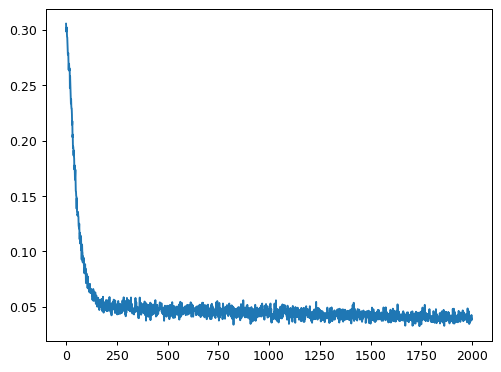

In [8]:
# define the batchsize
batchsize=1000

# Now: the training! (and plot the cost function)
eta=.01
batches=2000
costs=zeros(batches)

for k in range(batches):
    y_in,y_target=make_batch()
    costs[k]=train_net(y_in,y_target,eta)

plt.plot(costs)
plt.show()


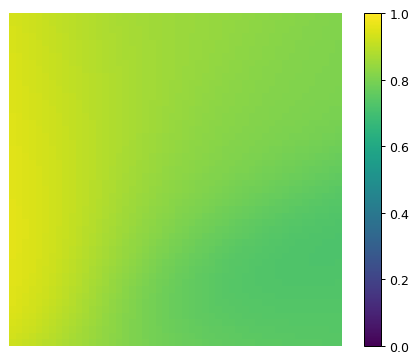

In [10]:
# a 'test' batch that includes all the points on the image grid
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

# check the output of this net
testoutput=apply_net_simple(testsample)

# show this!
myim=plt.imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
plt.colorbar()
plt.show()

# Animate learning progress

You need about a million or so samples to get something reasonable looking
i.e. at least resembling the shape

EXERCISE: find better parameters, for weight initialization, for learning rate, for batchsize etc., to reduce the number of samples needed!



In [11]:
# set up all the weights and biases

NumLayers=3 # does not count input-layer (but does count output)
LayerSizes=[2,150,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[5*(1./sqrt(LayerSizes[j]))*random.randn(LayerSizes[j],LayerSizes[j+1]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]



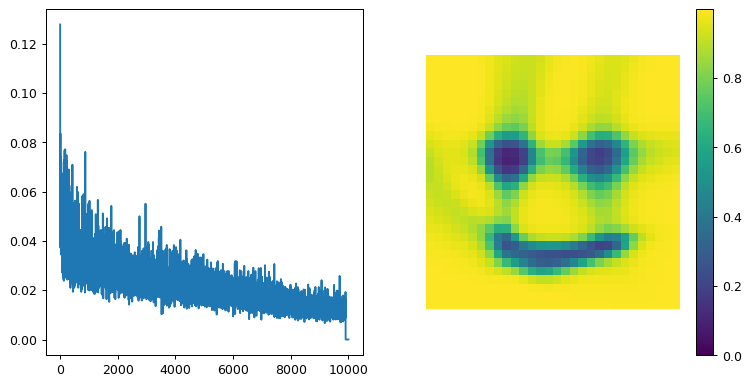

In [15]:

# test sample
Npixels_Test=30 # do the test output on a low-res grid! (saves time)
xrange=linspace(0,1,Npixels_Test)
X0,X1=meshgrid(xrange,xrange)
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

# parameters
eta=3.0
nsteps=10000
nskip_steps=100
batchsize=200

samples_count=0
costs=zeros(nsteps)

for j in range(nsteps):
    y_in,y_target=make_batch()
    costs[j]=train_net(y_in,y_target,eta)
    samples_count+=batchsize
    testoutput=apply_net_simple(testsample)  
    if j%nskip_steps==0: # time to plot again!
        clear_output(wait=True)
        fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
        img=ax[1].imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='nearest',vmin=0)
        fig.colorbar(img,ax=ax[1])
        ax[1].axis('off') # no axes
        ax[0].plot(costs)
        plt.show()

AllOldWeights=Weights # backup all weights
OldWeights=Weights[-1] # especially of last layer, which we will modify below!

In [13]:
samples_count

2000000

In [ ]:
# save the resulting network
#savez_compressed("ImageCompression_Network_Smiley.npz",LayerSizes,Weights,Biases)

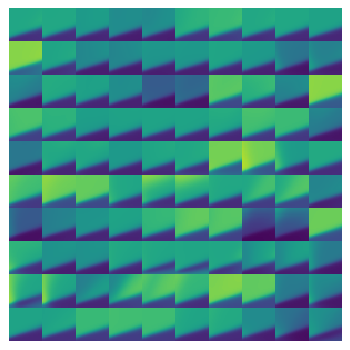

In [14]:
# switch on only individual neurons of last hidden layer
# and plot the resulting pictures in a big 10x10 array!
#data=load("ImageCompression_Network_Smiley.npz")
#Weights=data['arr_1']

Nrow=10
BigImage=zeros([Nrow*Npixels_Test,Nrow*Npixels_Test])
for which in range(100):
    Weights[-1]=OldWeights.copy()
    Weights[-1][0:which-1,:]=0
    Weights[-1][which+1:-1,:]=0
    testoutput=apply_net_simple(testsample)
    row=int(which/Nrow)
    column=which%Nrow
    BigImage[Npixels_Test*row:Npixels_Test*(row+1),Npixels_Test*column:Npixels_Test*(column+1)]=reshape(testoutput,shape(X0))
    #print(row,column)
myim=plt.imshow(BigImage,origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
plt.show()